In [1]:
import os
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [2]:
data_dir = r'C:\Users\haris\AI\ML\Projects\Data\Cars Dataset'

img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255,
    horizontal_flip = True,                         
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

datagen2 = ImageDataGenerator(rescale=1./255, horizontal_flip = False, validation_split=0.2)

datagen3 = ImageDataGenerator(rescale=1./255, horizontal_flip = False)

train_images = datagen.flow_from_directory(
                                          os.path.join(data_dir, 'train'),
                                          target_size = img_size,
                                          class_mode = "categorical",
                                          shuffle = True,
                                          batch_size = batch_size,
                                          subset = 'training')

valid_images = datagen2.flow_from_directory(os.path.join(data_dir, 'train'),
                                           target_size = img_size,
                                           class_mode = "categorical",
                                           shuffle = False,
                                           batch_size = batch_size,
                                           subset = 'validation')
test_images = datagen3.flow_from_directory(os.path.join(data_dir, 'test'),
                                           target_size = img_size,
                                           class_mode = "categorical",
                                           shuffle = False,
                                           batch_size = batch_size)

Found 3352 images belonging to 7 classes.
Found 668 images belonging to 7 classes.
Found 813 images belonging to 7 classes.


In [3]:
base_model = MobileNetV2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization() (x)
x = Dense(1024, activation = "relu") (x)
x = Dropout(0.3) (x)
x = Dense(512, activation = "relu") (x)
x = Dropout(0.25) (x)
x = Dense(128, activation = "relu") (x)
x = Dropout(0.15) (x)
x = Dense(64, activation = "relu") (x)
x = Dropout(0.15) (x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor="val_accuracy",patience  = 5,verbose=1, restore_best_weights=True)

history = model.fit(
    train_images,
    validation_data=valid_images,
    batch_size=batch_size,
    epochs=100,
    callbacks=[early_stopping]
)


Epoch 1/100
105/105 [==============================] - 37s 307ms/step - loss: 1.1829 - accuracy: 0.5880 - val_loss: 0.7019 - val_accuracy: 0.8009
Epoch 2/100
105/105 [==============================] - 31s 292ms/step - loss: 0.8114 - accuracy: 0.7363 - val_loss: 0.4333 - val_accuracy: 0.8683
Epoch 3/100
105/105 [==============================] - 31s 293ms/step - loss: 0.6311 - accuracy: 0.7921 - val_loss: 0.3666 - val_accuracy: 0.8787
Epoch 4/100
105/105 [==============================] - 31s 292ms/step - loss: 0.5568 - accuracy: 0.8207 - val_loss: 0.3029 - val_accuracy: 0.8937
Epoch 5/100
105/105 [==============================] - 31s 298ms/step - loss: 0.5000 - accuracy: 0.8335 - val_loss: 0.2897 - val_accuracy: 0.8937
Epoch 6/100
105/105 [==============================] - 31s 294ms/step - loss: 0.4569 - accuracy: 0.8493 - val_loss: 0.2437 - val_accuracy: 0.9222
Epoch 7/100
105/105 [==============================] - 31s 294ms/step - loss: 0.4161 - accuracy: 0.8708 - val_loss: 0.2560 -

In [4]:
num_epochs = len(history.history['loss'])
print(num_epochs)

num_batches_per_epoch = history.params['steps']
print(num_batches_per_epoch)

total_images_processed = num_epochs * num_batches_per_epoch * batch_size

print("Total number of images processed during training:", total_images_processed)

29
105
Total number of images processed during training: 97440


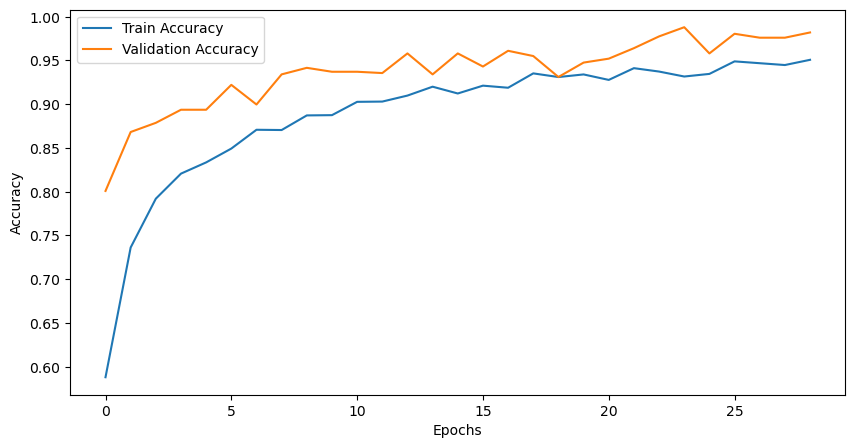

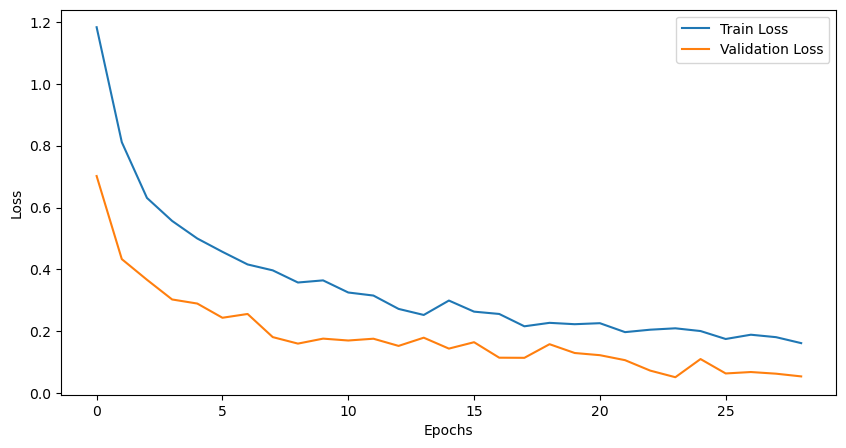

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')  
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

26/26 [==============================] - 1s 42ms/step - loss: 0.3026 - accuracy: 0.8991
Test Loss: 0.30264952778816223
Test Accuracy: 0.8991389870643616
26/26 [==============================] - 2s 43ms/step
Classification Report:
                   precision    recall  f1-score   support

            Audi       0.94      0.86      0.90       199
   Hyundai Creta       0.78      0.85      0.81        67
Mahindra Scorpio       0.96      0.85      0.90        75
     Rolls Royce       0.74      0.88      0.80        74
           Swift       0.89      0.89      0.89       102
     Tata Safari       0.92      0.96      0.94       106
   Toyota Innova       0.95      0.95      0.95       190

        accuracy                           0.90       813
       macro avg       0.88      0.89      0.89       813
    weighted avg       0.90      0.90      0.90       813



<AxesSubplot:>

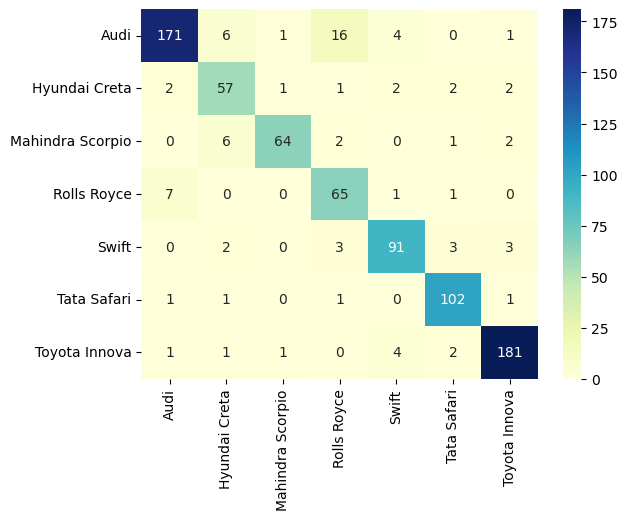

In [6]:
true_classes = test_images.classes

class_names = list(test_images.class_indices.keys())

test_evaluation = model.evaluate(test_images)

test_loss = test_evaluation[0]
test_accuracy = test_evaluation[1]

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)

confusion_mat = confusion_matrix(true_classes, test_predictions_classes)

classification_rep = classification_report(true_classes, test_predictions_classes, target_names=class_names)
print("Classification Report:\n", classification_rep)

import seaborn as sn
df_cm = pd.DataFrame(confusion_mat, index=class_names, columns=class_names)
sn.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")

In [7]:
classification_dict = classification_report(true_classes, test_predictions_classes, target_names=class_names, output_dict=True)
classification_df = pd.DataFrame(classification_dict).transpose()

excel_path = os.path.join(r'C:\Users\haris\AI\ML\Projects\Data\Cars Dataset', 'classification_report.xlsx')
classification_df.to_excel(excel_path, index=True)

print(f"Classification report saved as Excel to {excel_path}")

Classification report saved as Excel to C:\Users\haris\AI\ML\Projects\Data\Cars Dataset\classification_report.xlsx


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                           